In [144]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import jax
import optax
import matplotlib.pyplot as plt
import importlib
from pathlib import Path

# Force reload of project files
import data, train, models, evaluate, metrics
importlib.reload(data)
from data import TAPDataset, TAPDataLoader

data_dir = Path("../data/wqp")
basin_list_file = data_dir / "metadata" / "site_lists" / "sites_all.txt"
# basin_list_file = data_dir / "metadata" / "site_lists" / "sites_ssc_area1000_n10.txt"
sequence_length = 30
batch_size = 16

with open(basin_list_file, 'r') as file:
    basin_list = file.readlines()
    basin_list = [basin.strip() for basin in basin_list]

data_params = {'data_dir': data_dir,
               'basin_list': basin_list,
               'features_dict': {'daily':['grfr_q'],
                                 'irregular':['turbidity']},#['Blue','Green','Red','Nir','Swir1','Swir2']},
               'target': 'turbidity',
               'time_slice': slice('1979-01-01', '2018-12-31'),
               'split_time': np.datetime64('2010-01-01'),
               'train': True,
               'sequence_length': sequence_length,
               'log_norm_cols': ['turbidity', 'grfr_q'],
               'clip_target_to_zero': True,
               'discharge_col': 'grfr_q'}

dataset = TAPDataset(**data_params)

Dropping static attributes with 0 variance: ['glc_pc_s03', 'glc_pc_s05', 'glc_pc_s07', 'glc_pc_s08', 'glc_pc_s17', 'glc_pc_s19', 'pnv_pc_s03', 'wet_pc_s05', 'wet_pc_s06', 'wet_pc_s07']


Loading Basins:   0%|          | 0/1867 [00:00<?, ?it/s]

In [145]:
loader_params = {'suffle': True,
                 'batch_size': 16,
                 'num_workers': 0,
                 'pin_memory': True} 

dataloader = TAPDataLoader(dataset, **loader_params)

Dataloader using 0 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


In [ ]:
importlib.reload(models)
importlib.reload(train)
from models import simpleANN, ANN, HybridModel
from train import Trainer


daily_in_size = len(data_params['features_dict']['daily'])
irregular_in_size = len(data_params['features_dict']['irregular'])
static_in_size = dataloader.dataset.x_s[basin_list[0]].shape[0]
output_size = 1
hidden_size = 256
dropout = 0.4
key = jax.random.PRNGKey(0)

num_epochs = 250
# lr_schedule = optax.polynomial_schedule(0.01, 0.0001, 2, num_epochs)
lr_schedule = optax.exponential_decay(0.01, num_epochs, 0.3)

# model_args = {'dynamic_in_size': irregular_in_size+daily_in_size, 
#               'dynamic_hidden_size': 64, 
#               'num_dynamic_layers': 2,
#               'static_in_size': static_in_size,
#               'static_hidden_size': 8,
#               'num_static_layers': 2,
#               'output_size': 1,
#               'key': jax.random.PRNGKey(0), 
#               'dropout': 0}
# ann = ANN(**model_args)


model_args = {'in_size': irregular_in_size,
              # 'in_size': irregular_in_size+daily_in_size+static_in_size, 
              'hidden_size': 64, 
              'num_hidden_layers': 1,
              'output_size': 1,
              'key': jax.random.PRNGKey(0), 
              'dropout': 0}
ann = simpleANN(**model_args)
# model = HybridModel((irregular_in_size, hidden_size, hidden_size, output_size), daily_in_size, static_in_size, output_size, hidden_size, key=key, dropout=dropout)

dataloader.set_mode(train=True, sequence=False, end2end=False)
trainer = Trainer(ann, dataloader, lr_schedule, num_epochs, max_grad_norm=2)
model = trainer.start_training()


Output()

Training finished or interrupted. Model state saved.


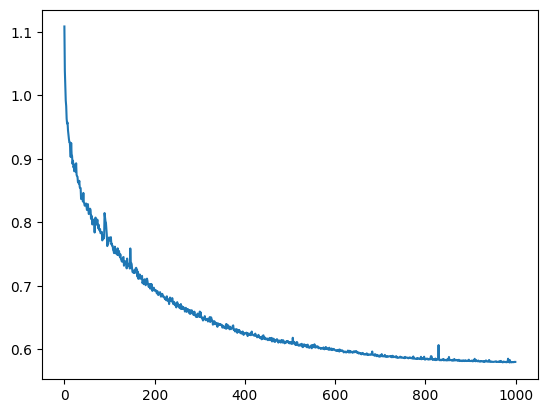

In [3]:
trainer.num_epochs=1000
model = trainer.start_training()

In [177]:
from metrics import get_all_metrics

importlib.reload(evaluate)
from evaluate import predict

#Need a sr evaluate mode. Maybe just rethink the entire indexing scheme.
dataloader.set_mode(train=False, sequence=False)
results = predict(ann, dataloader, denormalize=True)
results['pred'] = results['pred'] * (results['pred']>0) #Clip predictions to 0
metrics = get_all_metrics(results['obs'],results['pred'])
metrics

  0%|          | 0/12163 [00:00<?, ?it/s]

{'mse': 2.1345446,
 'rmse': 1.4610081,
 'kge': -138.5683537406244,
 'nse': -1250.393310546875}

In [179]:
results.obs.mean()

0.00029654047

In [175]:
dataset.scale

{'grfr_q': {'offset': 0.9424365, 'scale': 1, 'log_norm': True},
 'turbidity': {'offset': 2.408318424440369, 'scale': 1, 'log_norm': True}}

(array([5.1430e+04, 4.2802e+04, 9.6950e+03, 4.7231e+04, 3.6695e+04,
        4.3000e+03, 1.7890e+03, 5.6900e+02, 7.8000e+01, 1.6000e+01]),
 array([-0.09892274, -0.07465982, -0.05039692, -0.02613401, -0.0018711 ,
         0.02239181,  0.04665472,  0.07091762,  0.09518053,  0.11944345,
         0.14370635]),
 <BarContainer object of 10 artists>)

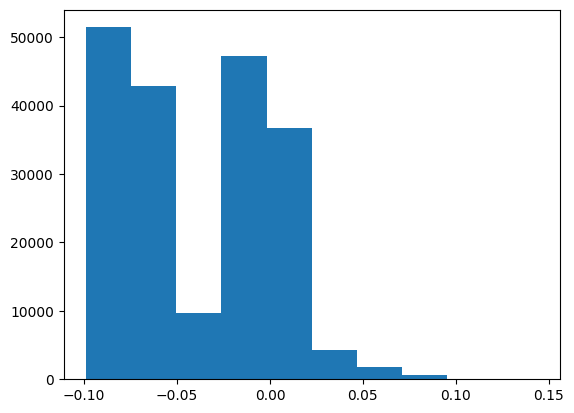

In [183]:
plt.hist(results.pred)

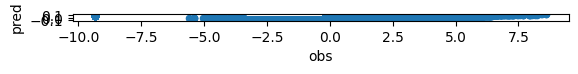

In [185]:
results.plot.scatter('obs','pred')
plt.gca().set_aspect('equal')
# plt.xlim([0,200])
# plt.ylim([0,200])
plt.show()

In [ ]:
for _, _, batch in dataloader:
    break
jax.vmap(ann)(batch)

Array([-1.4290591 ,  0.32053804], dtype=float32)

  0%|          | 0/575 [00:00<?, ?it/s]

(array([2.770e+02, 1.359e+03, 9.930e+02, 4.960e+02, 1.650e+02, 8.500e+01,
        5.000e+01, 1.400e+01, 1.000e+01, 1.000e+00]),
 array([-1.88365138, -1.14916539, -0.41467944,  0.31980655,  1.05429256,
         1.78877854,  2.52326441,  3.25775051,  3.99223638,  4.72672224,
         5.46120834]),
 <BarContainer object of 10 artists>)

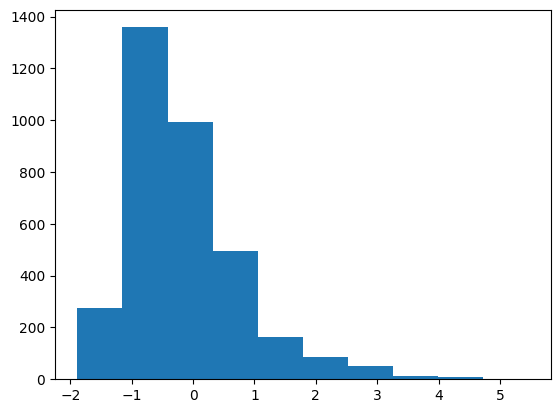

In [143]:
dataloader.set_mode(train=True, sequence=False, end2end=False)
x = []
for _, _, batch in tqdm(dataloader):
    x.extend(batch['x_di'][5,:])
xt = np.array(x).flatten()
# xt = dataloader.dataset.denormalize_target(xt)
plt.hist(xt)

In [137]:
batch['x_di'][17,:]

Array([-0.87810177, -0.7692972 , -0.86223024, -0.8211173 , -0.9552031 ,
       -0.908461  ], dtype=float32)

(array([6.000e+00, 0.000e+00, 2.000e+00, 8.400e+01, 1.147e+03, 4.448e+03,
        2.655e+03, 7.080e+02, 1.250e+02, 1.300e+01]),
 array([-9.31607342, -7.72350121, -6.13092852, -4.5383563 , -2.94578409,
        -1.35321164,  0.23936072,  1.83193302,  3.42450547,  5.01707792,
         6.60965014]),
 <BarContainer object of 10 artists>)

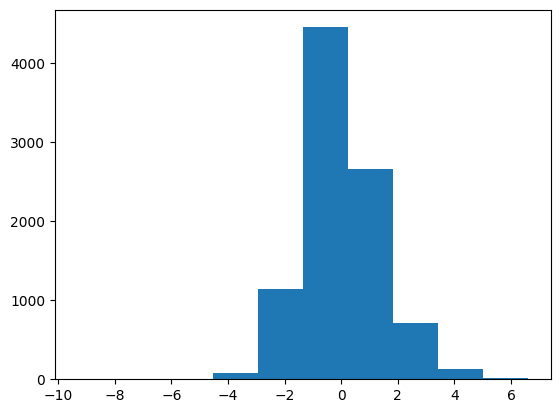

In [32]:
xt = np.array(x).flatten()
# xt = dataloader.dataset.denormalize_target(xt)
plt.hist(xt)

In [ ]:
dataloader.dataset.scale